In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Decision Tree

In [10]:
# Load dataset
df = pd.read_csv('../data/preprocessed-data.csv')
df.fillna(df.mean(), inplace=True)

# Split features and target
X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train+val into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 60/20/20 split

test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv('../data/test-data.csv', index=False)

# Initialize and train the model
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)

# Predict 
y_val_pred = dt_model.predict(X_val)
y_test_pred = dt_model.predict(X_test)



In [11]:
df.isna().sum().sum()

np.int64(0)

In [12]:
# Initial model evaluation

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Validation Set Metrics:
Accuracy: 0.8593704269779845
ROC-AUC: 0.5325510123158306

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     56552
           1       0.14      0.14      0.14      4950

    accuracy                           0.86     61502
   macro avg       0.53      0.53      0.53     61502
weighted avg       0.86      0.86      0.86     61502

Confusion Matrix:
 [[52145  4407]
 [ 4242   708]]

Test Set Metrics:
Accuracy: 0.8591102728366558
ROC-AUC: 0.5315307314715721

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     56574
           1       0.14      0.14      0.14      4928

    accuracy                           0.86     61502
   macro avg       0.53      0.53      0.53     61502
weighted avg       0.86      0.86      0.86     61502

Confusion Matrix:
 [[52140  4434]
 [ 4231   697]]


**The model is not performing well for the minority class (Class 1). The high accuracy is deceptive due to the highly imbalanced dataset.**

**Basically, the model is effectively failing to correctly classify the minority class (Class 1).**

**So trying to apply oversampling to the minority class through SMOTE**

In [6]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X_train, y_train = smt.fit_resample(X_train, y_train)


In [7]:
(y_train == 0).sum() / len(y_train)

np.float64(0.5)

Dataset is now balanced

In [8]:
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)

# Predict again
y_val_pred = dt_model.predict(X_val)
y_test_pred = dt_model.predict(X_test)

In [9]:

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Validation Set Metrics:
Accuracy: 0.7939741797014731
ROC-AUC: 0.5403100998669679

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88     56552
           1       0.12      0.24      0.16      4950

    accuracy                           0.79     61502
   macro avg       0.52      0.54      0.52     61502
weighted avg       0.86      0.79      0.82     61502

Confusion Matrix:
 [[47653  8899]
 [ 3772  1178]]

Test Set Metrics:
Accuracy: 0.7946896035901272
ROC-AUC: 0.542918797825535

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.84      0.88     56574
           1       0.12      0.24      0.16      4928

    accuracy                           0.79     61502
   macro avg       0.52      0.54      0.52     61502
weighted avg       0.86      0.79      0.83     61502

Confusion Matrix:
 [[47677  8897]
 [ 3730  1198]]


**After applying SMOTE to balance the training data, overall accuracy dropped to ~79%, but the model's performance on the minority class improved significantly. Recall for class 1 increased from ~14% to ~24%, and ROC-AUC slightly improved to 0.54. This indicates the model became more sensitive to minority class instances at the cost of some overall accuracy.**

# Hyperparameter Tuning

In [13]:
# Using GridSearch to find the best parameters
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}

dt = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='roc_auc', verbose=1)

In [14]:
# best one
best_dt = grid_search.best_estimator_

# Predict
y_val_pred = best_dt.predict(X_val)
y_test_pred = best_dt.predict(X_test)


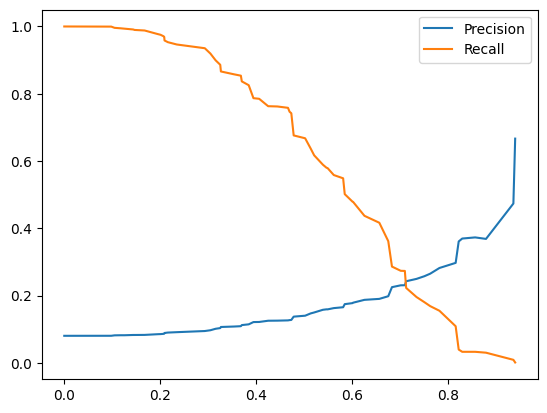

In [15]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


y_probs = best_dt.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)

# Plot precision-recall vs threshold
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.legend()
plt.show()


In [16]:

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


Validation Set Metrics:
Accuracy: 0.6438489805209586
ROC-AUC: 0.6547200502692793

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.64      0.77     56552
           1       0.14      0.67      0.23      4950

    accuracy                           0.64     61502
   macro avg       0.55      0.65      0.50     61502
weighted avg       0.89      0.64      0.73     61502

Confusion Matrix:
 [[36293 20259]
 [ 1645  3305]]

Test Set Metrics:
Accuracy: 0.645393645735098
ROC-AUC: 0.657203096025479

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.64      0.77     56574
           1       0.14      0.67      0.23      4928

    accuracy                           0.65     61502
   macro avg       0.55      0.66      0.50     61502
weighted avg       0.89      0.65      0.73     61502

Confusion Matrix:
 [[36385 20189]
 [ 1620  3308]]


**The hyperparameter tuning optimized for ROC-AUC using class_weight='balanced', leading the model to better detect defaulters (class 1) at the expense of increased false positives. This improved ROC-AUC and recall but reduced overall accuracy. The grid search likely selected a model that over-prioritized the minority class due to the chosen scoring metric and class weight balancing.**

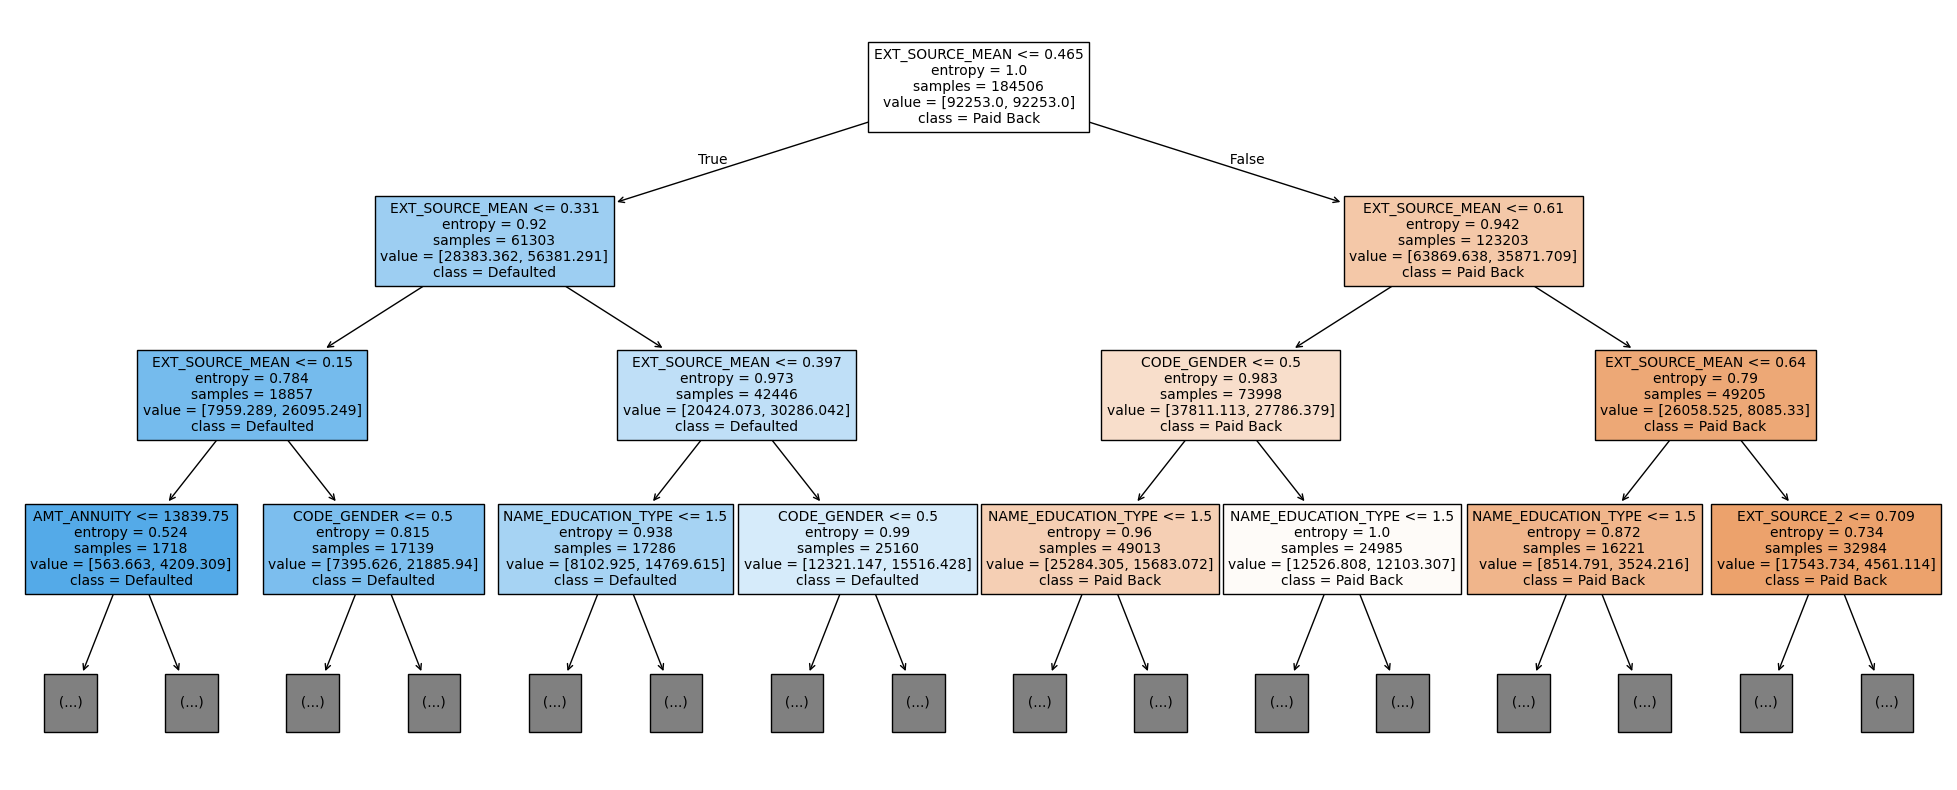

In [17]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 10))
plot_tree(best_dt,
          feature_names=X_val.columns,
          class_names=['Paid Back', 'Defaulted'],
          filled=True,
          max_depth=3,   # Show only top levels
          fontsize=10)
plt.savefig('../results/decision-tree.png')
plt.show()


In [18]:
# Saving model through pickle library
import pickle

with open('../models/decision-tree_model.pkl', 'wb') as f:
    pickle.dump(best_dt, f)


# Comparing with other models

## Random Forest

Validation Set Metrics:
Accuracy: 0.9187668693701018
ROC-AUC: 0.5030957045343805

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56552
           1       0.31      0.01      0.01      4950

    accuracy                           0.92     61502
   macro avg       0.62      0.50      0.49     61502
weighted avg       0.87      0.92      0.88     61502

Confusion Matrix:
 [[56468    84]
 [ 4912    38]]

Test Set Metrics:
Accuracy: 0.9192871776527592
ROC-AUC: 0.5048687238275212

Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56574
           1       0.38      0.01      0.02      4928

    accuracy                           0.92     61502
   macro avg       0.65      0.50      0.49     61502
weighted avg       0.88      0.92      0.88     61502

Confusion Matrix:
 [[56482    92]
 [ 4872    56]]


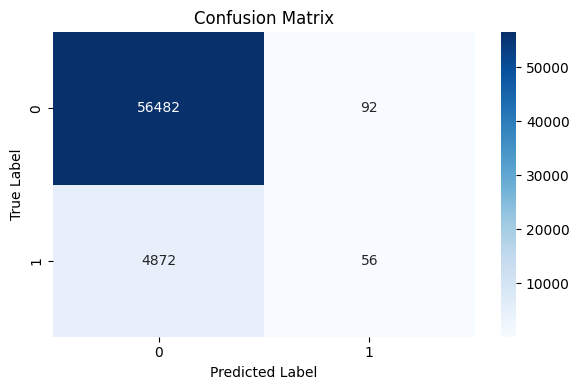

In [19]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
cm = confusion_matrix(y_test, y_test_pred)
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("===================================================")

**Despite having the highest overall accuracy(91%), Random Forest fails to detect class 1 instances, classifying nearly all as class 0. This leads to extremely poor recall. The imbalance in prediction is likely due to model bias towards majority class, even after SMOTE, possibly because Random Forest inherently prefers stable splits which are skewed when there's still class imbalance in real structure.**

## Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

# Impute missing values in training data
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)


lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_imputed, y_train)

y_val_pred = lr.predict(X_val_imputed)
y_test_pred = lr.predict(X_test_imputed)

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("===================================================")


Validation Set Metrics:
Accuracy: 0.6751325160157393
ROC-AUC: 0.6615923880193932

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.68      0.79     56552
           1       0.15      0.65      0.24      4950

    accuracy                           0.68     61502
   macro avg       0.55      0.66      0.52     61502
weighted avg       0.89      0.68      0.75     61502

Confusion Matrix:
 [[38327 18225]
 [ 1755  3195]]

Test Set Metrics:
Accuracy: 0.6743683132255862
ROC-AUC: 0.6630417130660727

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.68      0.79     56574
           1       0.15      0.65      0.24      4928

    accuracy                           0.67     61502
   macro avg       0.55      0.66      0.52     61502
weighted avg       0.89      0.67      0.75     61502

Confusion Matrix:
 [[38274 18300]
 [ 1727  3201]]


/home/abdullah-bin-mansoor/Desktop/AiGenMat Internship 25/Loan Default DT Classification/loan-default-classification/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Logistic Regression balances recall and ROC-AUC well, performing almost as well as Hyperparameter tuned DT in terms of recall but with higher accuracy and ROC-AUC. This makes it a more balanced option overall. However, convergence issues due to unscaled data may mean it's not performing optimally yet.**

## XGBoost

In [21]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    scale_pos_weight=11.4,  # ~ ratio of class 0 / class 1
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

y_val_pred = xgb.predict(X_val)
y_test_pred = xgb.predict(X_test)

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("===================================================")

/home/abdullah-bin-mansoor/Desktop/AiGenMat Internship 25/Loan Default DT Classification/loan-default-classification/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:50:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Set Metrics:
Accuracy: 0.6925628434847647
ROC-AUC: 0.6612083417282173

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.70      0.81     56552
           1       0.15      0.62      0.25      4950

    accuracy                           0.69     61502
   macro avg       0.55      0.66      0.53     61502
weighted avg       0.89      0.69      0.76     61502

Confusion Matrix:
 [[39506 17046]
 [ 1862  3088]]

Test Set Metrics:
Accuracy: 0.6943676628402329
ROC-AUC: 0.6632607795260913

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.70      0.81     56574
           1       0.15      0.63      0.25      4928

    accuracy                           0.69     61502
   macro avg       0.55      0.66      0.53     61502
weighted avg       0.89      0.69      0.76     61502

Confusion Matrix:
 [[39619 16955]
 [ 1842  3086]]


**XGBoost delivers a strong trade-off between recall and accuracy. Its higher accuracy and ROC-AUC than the decision tree suggest it handles the SMOTE-augmented class distributions more robustly. Boosting’s iterative nature helps capture subtle class 1 patterns without overfitting to noise.**

## Balanced Random Forest

In [22]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
clf.fit(X_train, y_train)


BalancedRandomForestClassifier(class_weight='balanced', max_depth=10,
                               n_estimators=200, random_state=42)

In [23]:

y_val_pred = clf.predict(X_val)
y_test_pred = clf.predict(X_test)

# Evaluation on validation set
print("Validation Set Metrics:")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

# Evaluation on test set
print("\nTest Set Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("===================================================")

Validation Set Metrics:
Accuracy: 0.12059770413970278
ROC-AUC: 0.517572024531637

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.04      0.09     56552
           1       0.08      0.99      0.15      4950

    accuracy                           0.12     61502
   macro avg       0.53      0.52      0.12     61502
weighted avg       0.91      0.12      0.09     61502

Confusion Matrix:
 [[ 2513 54039]
 [   46  4904]]

Test Set Metrics:
Accuracy: 0.11978472244805047
ROC-AUC: 0.5179435391538676

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.04      0.08     56574
           1       0.08      0.99      0.15      4928

    accuracy                           0.12     61502
   macro avg       0.53      0.52      0.12     61502
weighted avg       0.91      0.12      0.09     61502

Confusion Matrix:
 [[ 2478 54096]
 [   39  4889]]


**Balanced Random Forest aggressively prioritizes class 1 recall, detecting nearly all defaults, but at an extreme cost to accuracy,it misclassifies nearly the entire majority class. This makes it impractical unless recall is the only concern, such as in high-stakes fraud detection where false positives are acceptable.**

# FINAL OVERVIEW


If recall is the main goal , Balanced Random Forest and HPT Decision Tree are the best,but at the cost of many false alarms. If the goal is balanced general performance, XGBoost and Logistic Regression clearly outperform the HPT Decision Tree in ROC-AUC, accuracy, and precision, while maintaining strong recall. For high-precision needs with strict false positive control, Random Forest is most conservative but risks missing almost all defaulters.